# Imports

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import entropy
from sklearn.model_selection import GridSearchCV

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Functions

In [84]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]

def svm_tune_grid_search(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    model = SVC()
    
    param_grid = {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    
    return grid_search
  
def sentiment_score(review, tokenizer, model):
  tokens = tokenizer.encode(review, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits)) +1

def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(accuracy_score)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    for i in range(len(models)):
        model = models[i]
        # Evaluate the model
        scores = evaluate_model(X, y, model)
        # summarize and store
        print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
def logistic_regression_tune_cv(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    param_grid = {
        'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
        'C': [0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10, 20, 50, 100, 400]
    }
    model = LogisticRegression(class_weight='balanced', penalty='l2', max_iter=2000)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    
    return grid_search

def grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
            
        grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        # Predict on the test set
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
            
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Test accuracy for {name}: {accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Test Accuracy": accuracy,
                "Best Parameters": grid_search.best_params_
        })


    model_performance_df = pd.DataFrame(model_performance)
    print(model_performance_df)

# EDA Analysis

In [64]:
filename = "/Users/test/Downloads/Tweets.csv"

In [65]:
df_ = pd.read_csv(filename, nrows= 1000)
df_

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,569970938525016065,negative,1.0000,Late Flight,0.7065,United,NaN,tbird12lv,NaN,0,@united by the time I finally get to Dallas I ...,NaN,2015-02-23 13:23:55 -0800,Colorado,Mountain Time (US & Canada)
996,569970599377788928,negative,1.0000,Late Flight,1.0000,United,NaN,cristobalwong,NaN,0,@united I'm trying to get to my final destinat...,NaN,2015-02-23 13:22:35 -0800,San Francisco Bay Area,NaN
997,569970225443172353,negative,1.0000,Customer Service Issue,0.6667,United,NaN,itsmetsforme,NaN,0,@united that guy really has no customer servic...,NaN,2015-02-23 13:21:05 -0800,mets hell,NaN
998,569969999961391105,positive,0.6915,NaN,NaN,United,NaN,swampynomo,NaN,0,@united he has no priority and Iove it,NaN,2015-02-23 13:20:12 -0800,NJ/NYC,Eastern Time (US & Canada)


In [66]:
df = df_[["text",'airline_sentiment']].copy()
df

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
995,@united by the time I finally get to Dallas I ...,negative
996,@united I'm trying to get to my final destinat...,negative
997,@united that guy really has no customer servic...,negative
998,@united he has no priority and Iove it,positive


In [67]:
text_mapping = {"positive":1, 'neutral':0, "negative":2}

df['target'] = df['airline_sentiment'].map(text_mapping)

In [68]:
df

,text,airline_sentiment,target
0,@VirginAmerica What @dhepburn said.,neutral,0
1,@VirginAmerica plus you've added commercials t...,positive,1
2,@VirginAmerica I didn't today... Must mean I n...,neutral,0
3,@VirginAmerica it's really aggressive to blast...,negative,2
4,@VirginAmerica and it's a really big bad thing...,negative,2
...,...,...,...
995,@united by the time I finally get to Dallas I ...,negative,2
996,@united I'm trying to get to my final destinat...,negative,2
997,@united that guy really has no customer servic...,negative,2
998,@united he has no priority and Iove it,positive,1


In [69]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [70]:
df["berta_model"] = df["text"].apply(lambda review: sentiment_score(review, tokenizer, model))

In [71]:
df

,text,airline_sentiment,target,berta_model
0,@VirginAmerica What @dhepburn said.,neutral,0,5
1,@VirginAmerica plus you've added commercials t...,positive,1,5
2,@VirginAmerica I didn't today... Must mean I n...,neutral,0,1
3,@VirginAmerica it's really aggressive to blast...,negative,2,4
4,@VirginAmerica and it's a really big bad thing...,negative,2,1
...,...,...,...,...
995,@united by the time I finally get to Dallas I ...,negative,2,2
996,@united I'm trying to get to my final destinat...,negative,2,1
997,@united that guy really has no customer servic...,negative,2,1
998,@united he has no priority and Iove it,positive,1,1


<Axes: xlabel='berta_model'>

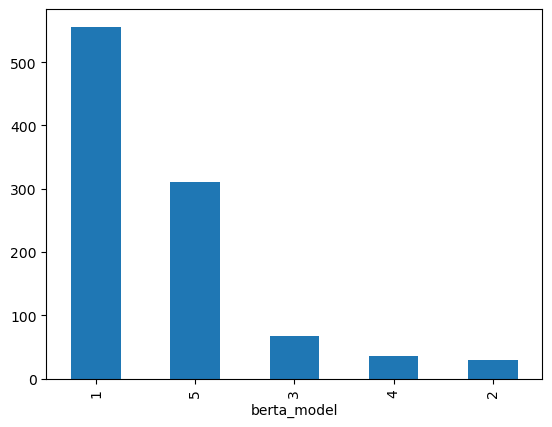

In [72]:
df["berta_model"].value_counts().plot.bar()

In [73]:
df["berta_model"].value_counts()

berta_model
1    556
5    310
3     68
4     36
2     30
Name: count, dtype: int64

In [74]:
df["target"].value_counts()

target
2    514
0    272
1    214
Name: count, dtype: int64

In [75]:
tfidf = TfidfVectorizer(max_features=3000)

In [76]:
# Applying TF-IDF to the specified column of the DataFrame
tfidf_matrix = tfidf.fit_transform(df['text'])

# Converting the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Concatenate the new DataFrame with the original DataFrame (optional)
# Make sure indexes align if not, reset index before concatenation.
df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

In [77]:
df

,text,airline_sentiment,target,berta_model,00,000,000114,000419,0011,0016,...,yul,yummy,yvr,zambia,zcbjyo6lsn,zcc82u,zero,zfqmpgxvs6,zone,zsuztnaijq
0,@VirginAmerica What @dhepburn said.,neutral,0,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,@VirginAmerica plus you've added commercials t...,positive,1,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,@VirginAmerica I didn't today... Must mean I n...,neutral,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,@VirginAmerica it's really aggressive to blast...,negative,2,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,@VirginAmerica and it's a really big bad thing...,negative,2,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,@united by the time I finally get to Dallas I ...,negative,2,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,@united I'm trying to get to my final destinat...,negative,2,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,@united that guy really has no customer servic...,negative,2,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,@united he has no priority and Iove it,positive,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
df.drop(["text", "airline_sentiment"], inplace=True, axis=1)

In [79]:
X,y = df.drop('target', axis=1), df['target']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [81]:
names = ["RFC", "DTC", "XGB", "LR", "SVC", "GBC"]
models = get_selected_models(names)
testing_selected_models(names, models, X, y)

>RFC 0.699 (0.042)
>DTC 0.614 (0.041)
>XGB 0.688 (0.046)
>LR 0.701 (0.034)
>SVC 0.655 (0.023)
>GBC 0.705 (0.043)


# LR Tune Model

In [82]:
logistic_regression_tune_cv(X, y)

Best parameters: {'C': 400, 'solver': 'newton-cg'}
Best cross-validation score: 0.721
Test accuracy: 0.653


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10, 20, 50, 100,
                               400],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
             scoring='accuracy')

# SVM Tune Model

In [83]:
svm_tune_grid_search(X, y)

Best parameters: {'C': 1, 'kernel': 'linear'}
Best cross-validation score: 0.716
Test accuracy: 0.683


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

## Hyper Parameter Tune

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Best score for RFC: 0.690
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Test accuracy for RFC: 0.707
---------------------------------------------------------------


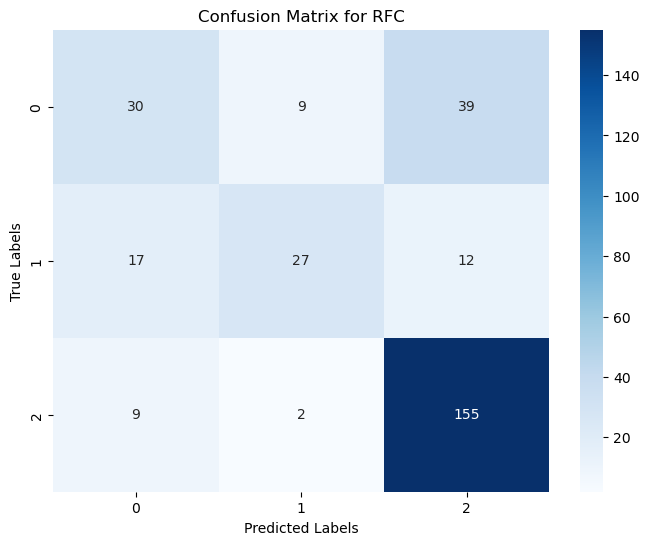

Best score for GBC: 0.693
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Test accuracy for GBC: 0.703
---------------------------------------------------------------


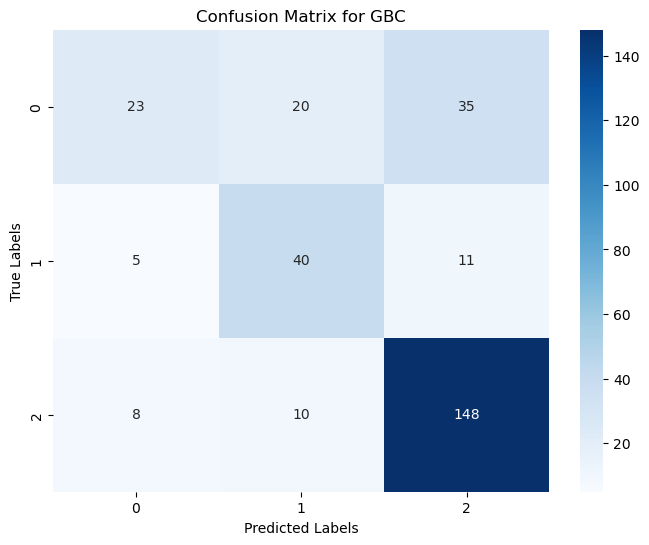

Best score for XGB: 0.694
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Test accuracy for XGB: 0.723
---------------------------------------------------------------


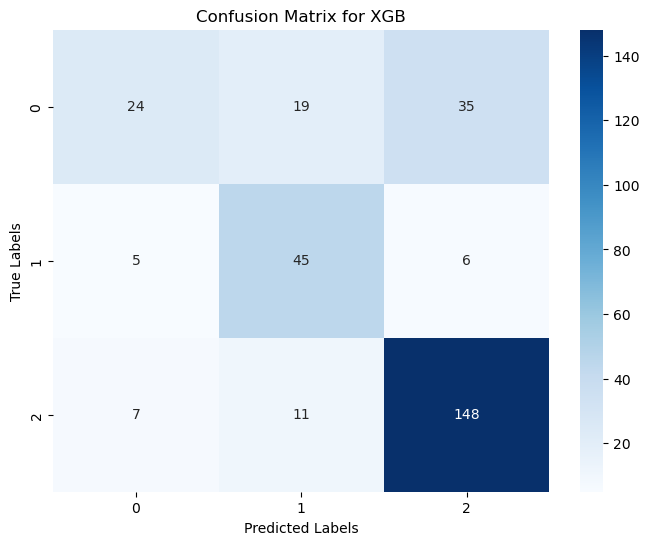

  Model  Best CV Score  Test Accuracy  \
0   RFC       0.690000       0.706667   
1   GBC       0.692857       0.703333   
2   XGB       0.694286       0.723333   

                                     Best Parameters  
0  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
1  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  
2  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  


In [90]:
names = ["RFC", "GBC", "XGB"]
models = get_selected_models(names)

param_grid = {
    'RFC': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    'GBC': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'XGB': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

metric = make_scorer(accuracy_score)

grid_search_selected_models(param_grid, names, models, X, y, metric)

# Conclusion

* Best model: Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
- Test accuracy for XGB: 0.723